In [1]:
import sys
sys.path.insert(1, '../..')
from utils import *
import cv2
import convml_tt
from convml_tt.system import TripletTrainerModel, TripletTrainerDataModule
from convml_tt.data.examples import fetch_example_dataset, ExampleData, fetch_pretrained_model, PretrainedModel
from convml_tt.data.dataset import TileType, ImageSingletDataset
from convml_tt.utils import get_embeddings
import convml_tt.interpretation
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import xarray as xr
import pandas as pd
import pytorch_lightning as pl
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import torch
from sklearn.decomposition import PCA
from PIL import Image
import os, shutil
from matplotlib.patches import Rectangle as rectan
from random import seed
from random import randint
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from convml_tt.interpretation.rectpred.transform import apply_transform
from convml_tt.data.examples import load_pretrained_model, PretrainedModel
from convml_tt.interpretation.rectpred.data import make_sliding_tile_model_predictions
from convml_tt.interpretation.rectpred.plot import make_rgb
from tqdm.notebook import tqdm
from math import sqrt, cos, sin
import random

TILE_FILENAME_FORMAT = "{triplet_id:05d}_{tile_type}.png"
TEST_SIZE = 0.3
RANDOM_STATE = 1024
COLORS = ['b', 'g', 'r', 'm'] # Color of each class
DATASET_DIR = "../../../NC/zooniverse/"
print(cv2.__version__)

pca = PCA(n_components=3, svd_solver='arpack')

4.5.2


In [2]:
df = pd.read_csv("../../../NC/zooniverse/train.csv")

In [3]:
df['Image'] = df['Image_Label'].map(lambda x: x.split('_')[0])
df['Class'] = df['Image_Label'].map(lambda x: x.split('_')[1])
classes = df['Class'].unique()
train_df = df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    df[class_name] = df['Class'].map(lambda x: 1 if class_name in x else 0)
df.head()

,Image_Label,EncodedPixels,Image,Class,Fish,Flower,Gravel,Sugar
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,1,0,0,0
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,0,1,0,0
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,0,0,1,0
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,0,0,0,1
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,1,0,0,0


In [4]:
# Creating training samples

image_col = np.array(df['Image'])
image_files = image_col[::4]
all_labels = df['Class']
X_train, y_train = image_files, all_labels
train_pairs = np.array(list(zip(X_train, y_train)))
TILE_FILENAME_FORMAT = "{triplet_id:05d}_{tile_type}.png"
NUM_TRAIN_SAMPLES = len(train_pairs)
train_samples = train_pairs[np.random.choice(train_pairs.shape[0], NUM_TRAIN_SAMPLES, replace=False), :]

# Creating dataset of rectangles divided in tiles.

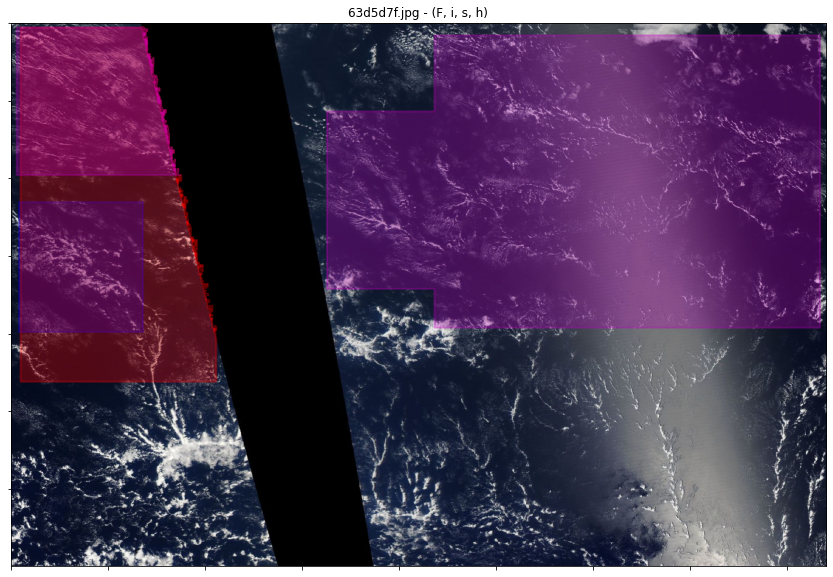

In [5]:

labs = []
shown = False
t = 0
for sample in tqdm(train_samples):
        if not shown:
            fig, ax = plt.subplots(figsize=(15, 10))
        img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #plt.imshow(img)
        #plt.show()
        # Get annotations
        labels = df[df['Image_Label'].str.contains(sample[0])]['EncodedPixels']

        patches = []
        for idx, rle in enumerate(labels.values):
            if rle is not np.nan:
                mask = rle2mask(rle)
                #maskn = mask.copy()
                #mask = np.ascontiguousarray(mask , dtype=np.uint8)
                contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                #print("Contours : "+str(contours))
                rgbImg = extract_contour(img, contours, shown=shown)
                rgbImg = cv2.cvtColor(rgbImg, cv2.COLOR_BGR2RGB)
                for x in range(0, rgbImg.shape[0], 256):
                    for y in range(0, rgbImg.shape[1], 256):
                        if rgbImg[x:x+256,y:y+256].shape != (256, 256, 3) or [0,0,0] in rgbImg[x:x+256,y:y+256]:
                            continue
                        
                        tm = t
                        out_name = TILE_FILENAME_FORMAT.format(triplet_id=tm,tile_type='anchor')
                        
                        out_name = '../NC/division/train/'+out_name
                        cv2.imwrite(out_name,rgbImg[x:x+256,y:y+256])
                        t += 1
                        labs.append(idx)
                if not shown:
                    for contour in contours:
                        poly_patch = Polygon(contour.reshape(-1, 2), closed=True, linewidth=2, edgecolor=COLORS[idx], facecolor=COLORS[idx], fill=True)
                        patches.append(poly_patch)
        if not shown:
            shown = True
            p = PatchCollection(patches, match_original=True, cmap=matplotlib.cm.jet, alpha=0.3)

            ax.imshow(img/255)
            ax.set_title('{} - ({})'.format(sample[0], ', '.join(sample[1].astype(np.str))))
            ax.add_collection(p)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.show()

# Creating division with rectangles resized as images

In [ ]:

labs_resized = []
shown = False
t = 0
for sample in tqdm(train_samples):
        if not shown:
            fig, ax = plt.subplots(figsize=(15, 10))
        img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #plt.imshow(img)
        #plt.show()
        # Get annotations
        labels = df[df['Image_Label'].str.contains(sample[0])]['EncodedPixels']

        patches = []
        for idx, rle in enumerate(labels.values):
            if rle is not np.nan:
                mask = rle2mask(rle)
                contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                rgbImg = extract_contour(img, contours, shown=shown)
                im = Image.fromarray(np.uint8(cm.gist_earth(rgbImg)*255))
                im = im.resize((256, 256))
                tm = t
                out_name = TILE_FILENAME_FORMAT.format(triplet_id=tm,tile_type='anchor')                
                out_name = '../NC/division/train/'+out_name
                im.save(out_name)
                t += 1

# Creating training dataset for the model.

In [6]:
import time
# 607
train_saving_path = '../../data/ZOONIVERSE/train/'
study_saving_path = '../../data/ZOONIVERSE/study/'
saving_path = train_saving_path
PI = 3.1456
t = 0
index_img = 0
for sample in tqdm(train_samples):
    if index_img < 0.81*train_samples.shape[0]:
        saving_path = train_saving_path
    else:
        saving_path = study_saving_path
    img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
    img = cv2.imread(img_path, 1)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get annotations
    labels = df[df['Image_Label'].str.contains(sample[0])]['EncodedPixels']

    for x in range(0, img.shape[0], 256):
        for y in range(0, img.shape[1], 256):
            if img[x:x+256,y:y+256].shape != (256, 256, 3):# or  [0,0,0] in rgbImg[x:x+256,y:y+256]:
                continue
            start = time.time()
            time.clock()    
            found = False # Variable meaning that we didn't find suiting neighobr tile
            best_neighbor = 0
            best_neighbor_img = []
            while not found: # Getting a neighbor image
                R = 256/2
                theta = random.random() * 2 * PI

                
                x_shift, y_shift = int(R * cos(theta)), int(R * sin(theta))
                neighobr_img = img[x+x_shift:x+x_shift+256,y+y_shift:y+y_shift+256]
                elapsed = time.time() - start
                if len(np.unique(neighobr_img.reshape(-1, neighobr_img.shape[2]), axis=0))>best_neighbor and neighobr_img.shape == (256, 256, 3):
                    best_neighbor = len(np.unique(neighobr_img.reshape(-1, neighobr_img.shape[2]), axis=0))
                    best_neighbor_img = neighobr_img

                if (not (neighobr_img.shape != (256, 256, 3) or len(np.unique(neighobr_img.reshape(-1, neighobr_img.shape[2]), axis=0))<30)) or elapsed>30:
                    found = True
            if [0, 0, 0] in best_neighbor_img:
                continue
            neighobr_img = best_neighbor_img
            found = False # distant

            while not found:
                random_img = train_samples[random.randint(0, train_samples.shape[0]-1)]
                if random_img[0] == sample[0]:
                    continue
                distant_img_path = os.path.join(DATASET_DIR, 'train_images', random_img[0])
                distant_img = cv2.imread(distant_img_path, 1)
                #distant_img = cv2.cvtColor(distant_img, cv2.COLOR_BGR2RGB)
                x_distant = random.randint(0, distant_img.shape[0]-257)
                y_distant = random.randint(0, distant_img.shape[1]-257)
                distant_img_shaped = distant_img[x_distant:x_distant+256,y_distant:y_distant+256]
                if not (distant_img_shaped.shape != (256, 256, 3) or [0,0,0] in distant_img_shaped):
                    found = True
                
            tm = t
            
            # anchor
            out_name = TILE_FILENAME_FORMAT.format(triplet_id=tm,tile_type='anchor')
            out_name = saving_path + out_name
            cv2.imwrite(out_name, img[x:x+256,y:y+256])

            # neighbor
            out_name_neighbor = TILE_FILENAME_FORMAT.format(triplet_id=tm,tile_type='neighbor')
            out_name_neighbor = saving_path + out_name_neighbor
            cv2.imwrite(out_name_neighbor, neighobr_img)

            # distant
            out_name_distant = TILE_FILENAME_FORMAT.format(triplet_id=tm,tile_type='distant')
            out_name_distant = saving_path + out_name_distant
            cv2.imwrite(out_name_distant, distant_img_shaped)

            t += 1
    index_img += 1

  0%|          | 0/5546 [00:00<?, ?it/s]

C:\Users\Ray\anaconda3\envs\convml_tt\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [6]:
import kornia
print(kornia.__version__)

0.3.0+a921e19


In [7]:
import torch

torch.cuda.is_available()

False